#  Core Sequence-Aware Agent Design v2

This experiment explores a transformer-based recurrent PPO agent for financial trading. The environment is sequence-aware and includes both regime-based augmentation and per-episode reward normalization. The agent is evaluated across top 2 stocks in each sector using structured episode sequences to assess learning generalization.

---

##  Experiment Configuration

| Parameter               | Value                         |
|-------------------------|-------------------------------|
| Agent                   | Recurrent PPO + Transformer   |
| Env Wrapper             | RegimeAugmentingWrapper + PerEpisodeRewardNormalizer |
| Episode Length          | 100                           |
| Episodes                | 20                            |
| Eval Episodes           | 3 per iteration               |
| Steps per Update        | 800                           |
| Batch Size              | 100                           |
| Total Timesteps         | 20,000                        |
| Learning Rate           | 0.0003                        |
| Entropy Coefficient     | 0.005                         |
| Value Function Coeff    | 0.5                           |
| Max Gradient Norm       | 0.5                           |
| Normalize Advantage     | True                          |
| Optimizer               | Adam                          |
| Transformer d_model     | 64                            |
| Heads                  | 4                             |
| Layers                 | 2                             |

---

## Environment Setup

- **Train Set:** 2023-01-01 → 2023-07-01
- **Test Set:** 2023-07-01 → 2024-01-01
- **Assets:** Top 2 stocks by sector
- **Sequence Split:** 80% train / 20% eval sequences

---

##  Agent Architecture

- **Feature Extractor:** Transformer encoder with causal mask and learnable positional encoding.
- **Policy Class:** Custom `TransformerPolicy` extending `RecurrentActorCriticPolicy`.
- **Reward Normalization:** Online normalization within episodes.
- **Regime Augmentation:** Appends one-hot encoded market regime to each timestep.

---

## Training Summary (Selected Stats)

| Timesteps | Ep Rew Mean | Explained Variance | Value Loss | Policy Grad Loss |
|-----------|-------------|--------------------|------------|------------------|
|  8000     | 3.21        | 0.15               | 4.68       | -0.00277         |
| 14400     | 2.90        | 0.645              | 1.71       |  0.00163         |
| 20000     | **3.79**    | **0.751**          | 1.59       | -0.00012         |

---

## Evaluation Snapshots

| Timestep | Mean Reward | Std Dev | Eval Length |
|----------|-------------|---------|-------------|
| 5000     | -8.17       | ±8.72   | 102         |
| 10000    | -4.43       | ±7.59   | 102         |
| 15000    | -6.17       | ±4.92   | 102         |
| 20000    | **0.24**    | ±2.86   | 102         |

---

## Statistical Significance

### Paired t-test and Mann-Whitney U-test

| Metric       | t-test p-value | Mann-Whitney p-value |
|--------------|----------------|-----------------------|
| `total_reward` | 0.0300         | 0.0075                |
| `calmar`       | 0.0132         | 0.0075                |

✅ Both `total_reward` and `calmar ratio` show **statistically significant** improvements compared to the baseline.  
Especially, Calmar implies **more stable and risk-adjusted returns**.

> Note: `sharpe`, `sortino`, and `final_wealth` were skipped due to empty values in the evaluation logs. Ensure metrics are logged and valid across all test episodes to include them.

---

## Next Steps

1. **Fix missing metrics** (`sharpe`, `sortino`, etc.) in the logging pipeline.
2. **Plot distribution comparisons** (boxplots, histograms) for rewards and risk-adjusted returns.
3. **Run ablation**:
   - Without regime augmentation
   - Without reward normalization
   - With simpler agents (e.g., MLP or LSTM)
4. **Test in unseen market conditions** or during volatility spikes to check robustness.

---

_Logged using `ExperimentTracker` — Run Hash: `${experiment_tracker.run_hash}`_


In [1]:
# SETUP ===================================
import jupyter
import warnings

from src.utils.system import boot, Notify

boot()
warnings.filterwarnings("ignore")



# PACKAGES ================================
import os
import torch
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import gymnasium as gym
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import  RobustScaler

# FRAMEWORK STUFF =========================
from src.defaults import TOP2_STOCK_BY_SECTOR, FEATURE_COLS,EPISODE_LENGTH
from src.data.feature_pipeline import load_base_dataframe
from src.experiments.experiment_tracker import ExperimentTracker
from src.env.base_timeseries_trading_env import BaseSequenceAwareTradingEnv,SequenceAwareAlphaTradingEnv,SequenceAwareBaselineTradingAgent,SequenceAwareCalmarTradingEnv,SequenceAwareCumulativeTradingEnv,SequenceAwareDrawdownTradingEnv,SequenceAwareHybridTradingEnv,SequenceAwareHybridTradingEnv,SequenceAwareSharpeTradingEnv,SequenceAwareSortinoTradingEnv

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy



In [23]:

# ========== CONFIG ==========
EXPERIENCE_NAME = "core_sequence_aware_agent_design_v2"
RESULTS_PATH = f"data/experiments/{EXPERIENCE_NAME}_barebones_results.csv"
N_EPISODES = 20
N_SEEDS = 3
N_EVAL_EPISODES = 3

WINDOW_LENGTH = 10  
TOTAL_TIMESTEPS = EPISODE_LENGTH * 150
N_STEPS = EPISODE_LENGTH * 2

TRANSACTION_COST = 0

CONFIG = {
    "batch_size": EPISODE_LENGTH,
    "n_steps": 800,
    "total_timesteps": TOTAL_TIMESTEPS,
    "project_name":EXPERIENCE_NAME
}




# Load data ==================================
ohlcv_df = load_base_dataframe()

# Experiment tracker ========================= 
experiment_tracker = ExperimentTracker(EXPERIENCE_NAME)
experiment_tracker.set_hash(CONFIG)

# Files ======================================
checkpoint_path = "data/checkpoint" 
checkpoint_name = experiment_tracker.run_hash
checkpoint_preffix = f"{checkpoint_name}--checkpoint"
checkpoint_best_model=f"{checkpoint_path}/{checkpoint_name}--best_model"
log_path="data/logs"
save_path= f"{checkpoint_path}/{checkpoint_name}--final"
print(save_path)

data/checkpoint/-8377624099423380081--final


In [3]:
EPISODE_LENGTH = 100
MAX_LENGTH = 200
SAVE_FREQ=10000
EVAL_FREQ=5000
TOTAL_TIMESTEPS=200000
#TOTAL_TIMESTEPS=1000
EPISODES_PER_UPDATE = 8          # ~how many episodes before PPO updates
EPISODES_PER_BATCH = 1           # number of full episodes per batch

# === Auto-derive PPO settings ===
N_STEPS = EPISODE_LENGTH * EPISODES_PER_UPDATE
BATCH_SIZE = EPISODE_LENGTH * EPISODES_PER_BATCH

ENV_CLASS = SequenceAwareCumulativeTradingEnv

n = Notify(experiment_tracker.project)
n.info('START')
print(N_STEPS,BATCH_SIZE)

800 100


In [4]:
import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy

# Causal Mask Function ============================
def generate_causal_mask(seq_len):
    return torch.triu(torch.ones((seq_len, seq_len), dtype=torch.bool), diagonal=1)

# Transformer Feature Extractor ===================
class TransformerFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, d_model=64, n_heads=4, n_layers=2, max_len=MAX_LENGTH):
        super().__init__(observation_space, features_dim=d_model)
        self.d_model = d_model
        input_dim = observation_space.shape[-1]

        self.input_proj = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.randn(max_len, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

    def forward_v1(self, obs):
        # obs shape: (batch, seq_len, input_dim)
        x = self.input_proj(obs)
        seq_len = x.size(1)
        x = x + self.positional_encoding[:seq_len]
        causal_mask = generate_causal_mask(seq_len).to(x.device)
        x = self.transformer(x, mask=causal_mask)
        return x[:, -1]  # return the last token output
    
    def forward(self, obs):
        # obs shape: (batch, seq_len, input_dim)
        #print(">>> [Transformer] Input shape:", obs.shape)

        x = self.input_proj(obs)
        seq_len = x.size(1)
        x = x + self.positional_encoding[:seq_len]

        causal_mask = generate_causal_mask(seq_len).to(x.device)
        x = self.transformer(x, mask=causal_mask)

        pooled_output = x[:, -1]
        #print(">>> [Transformer] Pooled output mean/std:", pooled_output.mean().item(), pooled_output.std().item())

        return pooled_output

# Transformer Policy ===================================
class TransformerPolicy(RecurrentActorCriticPolicy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs,
                         features_extractor_class=TransformerFeatureExtractor,
                         features_extractor_kwargs=dict(
                             d_model=64, n_heads=4, n_layers=2, max_len=32
                         ))
        #self._build(self.lr_schedule)

# Regime Augmentation Wrapper ===========================
class RegimeAugmentingWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.regime_dim = 3  # One-hot: bull, bear, sideways
        obs_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(obs_shape[0], obs_shape[1] + self.regime_dim),
            dtype=np.float32
        )

    def observation(self, obs):
        regime = self.env.get_current_regime()  # 0,1,2 -> bull,bear,sideways
        one_hot = np.zeros(self.regime_dim)
        one_hot[regime] = 1.0
        one_hot = np.repeat(one_hot[None, :], obs.shape[0], axis=0)
        return np.concatenate([obs, one_hot], axis=-1)

class PerEpisodeRewardNormalizer(gym.Wrapper):
    def reset(self, **kwargs):
        self.episode_rewards = []
        return self.env.reset(**kwargs)

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        self.episode_rewards.append(reward)
        mean = np.mean(self.episode_rewards)
        std = np.std(self.episode_rewards) + 1e-8
        norm_reward = (reward - mean) / std
        return obs, norm_reward, done, truncated, info
# Training =============================================================
train_df = ohlcv_df[(ohlcv_df['date']>="2023-01-01") & (ohlcv_df['date']<"2023-07-01")]
test_df = ohlcv_df[(ohlcv_df['date']>="2023-07-01") & (ohlcv_df['date']<"2024-01-01")]
train_df = train_df[train_df['symbol'].isin(TOP2_STOCK_BY_SECTOR)]
test_df = test_df[test_df['symbol'].isin(TOP2_STOCK_BY_SECTOR)]

train_env =ENV_CLASS(train_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
test_env =ENV_CLASS(test_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
# Train on few episodes to prove a point only
train_seq = train_env.generate_episode_sequences(TOTAL_TIMESTEPS)
_test_seq = test_env.generate_episode_sequences(int(TOTAL_TIMESTEPS))
episodes = _test_seq
unique_episodes = {}
for ticker, start in episodes:
    if ticker not in unique_episodes:
        unique_episodes[ticker] = start
# Convert back to a list of tuples
test_seq = [(ticker, start) for ticker, start in unique_episodes.items()]

print(f"Training on {len(train_seq)} different episodes accross the top 2 stocks for each sector")
print(f"Testing on {len(test_seq)} different episodes accross the top 2 stocks for each sector")
def train_agent():
    
    
    
    train_env =ENV_CLASS(train_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
    eval_env =ENV_CLASS(test_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
    train_env.set_episode_sequence(train_seq)
    eval_env.set_episode_sequence(test_seq)
    
    train_env = PerEpisodeRewardNormalizer(RegimeAugmentingWrapper(train_env))
    eval_env = PerEpisodeRewardNormalizer(RegimeAugmentingWrapper(eval_env))
    checkpoint_callback = CheckpointCallback(
        save_freq=SAVE_FREQ, save_path=checkpoint_path, name_prefix=checkpoint_preffix
    )

    eval_callback = EvalCallback(
        eval_env, best_model_save_path=checkpoint_best_model,
        log_path=log_path, eval_freq=EVAL_FREQ, deterministic=True
    )

    model = RecurrentPPO(
        policy=TransformerPolicy,
        env=train_env,
        verbose=1,
        #tensorboard_log="./tensorboard_logs",
        n_steps=N_STEPS,
        batch_size=BATCH_SIZE,
        learning_rate=3e-4,
        gamma=0.99,
        gae_lambda=0.95,
        ent_coef=0.005,
        vf_coef=0.5,
        max_grad_norm=0.5,
        normalize_advantage=True,
        policy_kwargs=dict(share_features_extractor=True)
    )

    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=[checkpoint_callback, eval_callback])
    model.save(save_path)

if __name__ == "__main__":
    train_agent()


Training on 1961 different episodes accross the top 2 stocks for each sector
Testing on 22 different episodes accross the top 2 stocks for each sector
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 1.57     |
| time/              |          |
|    fps             | 135      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 800      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | -1.87       |
| time/                   |             |
|    fps                  | 35          |
|    iterations           | 2           |
|    time_elapsed         | 44          |
|    total_timesteps      | 1600        |
| train/                  |          

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 2.26        |
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 11          |
|    time_elapsed         | 405         |
|    total_timesteps      | 8800        |
| train/                  |             |
|    approx_kl            | 0.007842662 |
|    clip_fraction        | 0.0136      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.857      |
|    explained_variance   | 0.0188      |
|    learning_rate        | 0.0003      |
|    loss                 | 2.69        |
|    n_updates            | 100         |
|    policy_gradient_loss | 0.000414    |
|    value_loss           | 5.86        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 6.63     |
| time/              |          |
|    fps             | 21       |
|    iterations      | 19       |
|    time_elapsed    | 722      |
|    total_timesteps | 15200    |
---------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 102       |
|    ep_rew_mean          | 6.46      |
| time/                   |           |
|    fps                  | 21        |
|    iterations           | 20        |
|    time_elapsed         | 759       |
|    total_timesteps      | 16000     |
| train/                  |           |
|    approx_kl            | 0.0373776 |
|    clip_fraction        | 0.11      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.887    |
|    explained_variance   | 0.56      |
|    learning_rate        | 0.0003    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 7.36        |
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 29          |
|    time_elapsed         | 1121        |
|    total_timesteps      | 23200       |
| train/                  |             |
|    approx_kl            | 0.011610093 |
|    clip_fraction        | 0.0441      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.79       |
|    explained_variance   | 0.74        |
|    learning_rate        | 0.0003      |
|    loss                 | 3.44        |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.00238    |
|    value_loss           | 2.89        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

Eval num_timesteps=30000, episode_reward=12.91 +/- 8.40
Episode length: 102.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 102        |
|    mean_reward          | 12.9       |
| time/                   |            |
|    total_timesteps      | 30000      |
| train/                  |            |
|    approx_kl            | 0.01776584 |
|    clip_fraction        | 0.0771     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.668     |
|    explained_variance   | 0.755      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.55       |
|    n_updates            | 370        |
|    policy_gradient_loss | 0.00566    |
|    value_loss           | 2.24       |
----------------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 7.22     |
| time/         

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 8.95        |
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 47          |
|    time_elapsed         | 1843        |
|    total_timesteps      | 37600       |
| train/                  |             |
|    approx_kl            | 0.023854688 |
|    clip_fraction        | 0.0931      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.577      |
|    explained_variance   | 0.896       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.858       |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.00742    |
|    value_loss           | 1.65        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 9.49        |
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 56          |
|    time_elapsed         | 2212        |
|    total_timesteps      | 44800       |
| train/                  |             |
|    approx_kl            | 0.012456128 |
|    clip_fraction        | 0.0519      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.682      |
|    explained_variance   | 0.727       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.35        |
|    n_updates            | 550         |
|    policy_gradient_loss | 0.00092     |
|    value_loss           | 1.7         |
-----------------------------------------
Eval num_timesteps=45000, episode_reward=-2.11 +/- 6.19
Episode length: 102.00 +/- 0.00
------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 9.46        |
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 65          |
|    time_elapsed         | 2571        |
|    total_timesteps      | 52000       |
| train/                  |             |
|    approx_kl            | 0.012778817 |
|    clip_fraction        | 0.0674      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.608      |
|    explained_variance   | 0.86        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.164       |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.00173    |
|    value_loss           | 0.744       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

Eval num_timesteps=60000, episode_reward=0.56 +/- 6.15
Episode length: 102.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 102        |
|    mean_reward          | 0.557      |
| time/                   |            |
|    total_timesteps      | 60000      |
| train/                  |            |
|    approx_kl            | 0.08764345 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.565     |
|    explained_variance   | 0.887      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.734      |
|    n_updates            | 740        |
|    policy_gradient_loss | -0.00896   |
|    value_loss           | 0.934      |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 9.56     |
| time/              |          |
|    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 9.61        |
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 84          |
|    time_elapsed         | 3351        |
|    total_timesteps      | 67200       |
| train/                  |             |
|    approx_kl            | 0.042675614 |
|    clip_fraction        | 0.0765      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.522      |
|    explained_variance   | 0.869       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.152       |
|    n_updates            | 830         |
|    policy_gradient_loss | -0.000252   |
|    value_loss           | 1.06        |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102     

Eval num_timesteps=75000, episode_reward=4.80 +/- 7.20
Episode length: 102.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 102        |
|    mean_reward          | 4.8        |
| time/                   |            |
|    total_timesteps      | 75000      |
| train/                  |            |
|    approx_kl            | 0.03605142 |
|    clip_fraction        | 0.0722     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.382     |
|    explained_variance   | 0.893      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0868     |
|    n_updates            | 930        |
|    policy_gradient_loss | -0.00533   |
|    value_loss           | 0.736      |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 11.4     |
| time/              |          |
|    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 13.6        |
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 103         |
|    time_elapsed         | 4095        |
|    total_timesteps      | 82400       |
| train/                  |             |
|    approx_kl            | 0.009414627 |
|    clip_fraction        | 0.0705      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.478      |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.2         |
|    n_updates            | 1020        |
|    policy_gradient_loss | 0.000728    |
|    value_loss           | 0.712       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 14.4       |
| time/                   |            |
|    fps                  | 20         |
|    iterations           | 112        |
|    time_elapsed         | 4450       |
|    total_timesteps      | 89600      |
| train/                  |            |
|    approx_kl            | 0.01284277 |
|    clip_fraction        | 0.0585     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.472     |
|    explained_variance   | 0.973      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.148      |
|    n_updates            | 1110       |
|    policy_gradient_loss | -0.00528   |
|    value_loss           | 0.644      |
----------------------------------------
Eval num_timesteps=90000, episode_reward=3.30 +/- 7.47
Episode length: 102.00 +/- 0.00
----------------------------------------
| eval/    

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 16.3       |
| time/                   |            |
|    fps                  | 20         |
|    iterations           | 121        |
|    time_elapsed         | 4801       |
|    total_timesteps      | 96800      |
| train/                  |            |
|    approx_kl            | 0.03232345 |
|    clip_fraction        | 0.0617     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.554     |
|    explained_variance   | 0.972      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.302      |
|    n_updates            | 1200       |
|    policy_gradient_loss | -0.0072    |
|    value_loss           | 0.848      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_m

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 16.4       |
| time/                   |            |
|    fps                  | 20         |
|    iterations           | 131        |
|    time_elapsed         | 5192       |
|    total_timesteps      | 104800     |
| train/                  |            |
|    approx_kl            | 0.02537325 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.476     |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.104      |
|    n_updates            | 1300       |
|    policy_gradient_loss | -0.00658   |
|    value_loss           | 0.881      |
----------------------------------------
Eval num_timesteps=105000, episode_reward=1.36 +/- 2.76
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 18.6        |
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 140         |
|    time_elapsed         | 5543        |
|    total_timesteps      | 112000      |
| train/                  |             |
|    approx_kl            | 0.012438458 |
|    clip_fraction        | 0.0891      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.446      |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.242       |
|    n_updates            | 1390        |
|    policy_gradient_loss | -0.00357    |
|    value_loss           | 0.793       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 20.3        |
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 149         |
|    time_elapsed         | 5891        |
|    total_timesteps      | 119200      |
| train/                  |             |
|    approx_kl            | 0.052056476 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.477      |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0847      |
|    n_updates            | 1480        |
|    policy_gradient_loss | -0.00539    |
|    value_loss           | 0.332       |
-----------------------------------------
Eval num_timesteps=120000, episode_reward=2.16 +/- 2.24
Episode length: 102.00 +/- 0.00
------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 20.5        |
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 158         |
|    time_elapsed         | 6250        |
|    total_timesteps      | 126400      |
| train/                  |             |
|    approx_kl            | 0.069102615 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.443      |
|    explained_variance   | 0.962       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.46        |
|    n_updates            | 1570        |
|    policy_gradient_loss | 0.00563     |
|    value_loss           | 0.784       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 20          |
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 167         |
|    time_elapsed         | 6592        |
|    total_timesteps      | 133600      |
| train/                  |             |
|    approx_kl            | 0.032256775 |
|    clip_fraction        | 0.0886      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.447      |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.274       |
|    n_updates            | 1660        |
|    policy_gradient_loss | -0.000662   |
|    value_loss           | 0.462       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 21.3        |
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 176         |
|    time_elapsed         | 6956        |
|    total_timesteps      | 140800      |
| train/                  |             |
|    approx_kl            | 0.020433301 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.519      |
|    explained_variance   | 0.942       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.65        |
|    n_updates            | 1750        |
|    policy_gradient_loss | 0.00375     |
|    value_loss           | 1.15        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 20.4       |
| time/                   |            |
|    fps                  | 20         |
|    iterations           | 186        |
|    time_elapsed         | 7335       |
|    total_timesteps      | 148800     |
| train/                  |            |
|    approx_kl            | 0.04823286 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.445     |
|    explained_variance   | 0.978      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.113      |
|    n_updates            | 1850       |
|    policy_gradient_loss | -0.00248   |
|    value_loss           | 0.587      |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 19.9       |
| time/                   |            |
|    fps                  | 20         |
|    iterations           | 195        |
|    time_elapsed         | 7701       |
|    total_timesteps      | 156000     |
| train/                  |            |
|    approx_kl            | 0.11967127 |
|    clip_fraction        | 0.209      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.428     |
|    explained_variance   | 0.977      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.17       |
|    n_updates            | 1940       |
|    policy_gradient_loss | 0.0294     |
|    value_loss           | 0.971      |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 20.1        |
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 205         |
|    time_elapsed         | 8082        |
|    total_timesteps      | 164000      |
| train/                  |             |
|    approx_kl            | 0.044591077 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.401      |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.242       |
|    n_updates            | 2040        |
|    policy_gradient_loss | 0.01        |
|    value_loss           | 0.463       |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102     

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 20.5       |
| time/                   |            |
|    fps                  | 20         |
|    iterations           | 214        |
|    time_elapsed         | 8443       |
|    total_timesteps      | 171200     |
| train/                  |            |
|    approx_kl            | 0.14924751 |
|    clip_fraction        | 0.156      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.343     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0003     |
|    loss                 | 0.953      |
|    n_updates            | 2130       |
|    policy_gradient_loss | 0.000372   |
|    value_loss           | 0.474      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_m

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 19.7       |
| time/                   |            |
|    fps                  | 20         |
|    iterations           | 223        |
|    time_elapsed         | 8790       |
|    total_timesteps      | 178400     |
| train/                  |            |
|    approx_kl            | 0.12244206 |
|    clip_fraction        | 0.172      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.398     |
|    explained_variance   | 0.941      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.456      |
|    n_updates            | 2220       |
|    policy_gradient_loss | 0.00771    |
|    value_loss           | 1.63       |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 19       |
| time/              |          |
|    fps             | 20       |
|    iterations      | 232      |
|    time_elapsed    | 9143     |
|    total_timesteps | 185600   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 19.2        |
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 233         |
|    time_elapsed         | 9187        |
|    total_timesteps      | 186400      |
| train/                  |             |
|    approx_kl            | 0.024976056 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.514      |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 21.9       |
| time/                   |            |
|    fps                  | 20         |
|    iterations           | 242        |
|    time_elapsed         | 9538       |
|    total_timesteps      | 193600     |
| train/                  |            |
|    approx_kl            | 0.08508023 |
|    clip_fraction        | 0.185      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.412     |
|    explained_variance   | 0.977      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.00512    |
|    n_updates            | 2410       |
|    policy_gradient_loss | -0.00699   |
|    value_loss           | 0.715      |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean

In [5]:
n = Notify(experiment_tracker.project)
n.info('DONE')

>>> [Eval] Obs shape: (10, 28)
>>> [Eval] Obs shape: (10, 28)
>>> [Eval] Obs shape: (10, 28)
>>> [Eval] Obs shape: (10, 28)
>>> [Eval] Obs shape: (10, 28)
>>> [Eval] Action counts: Series([], Name: count, dtype: int64)


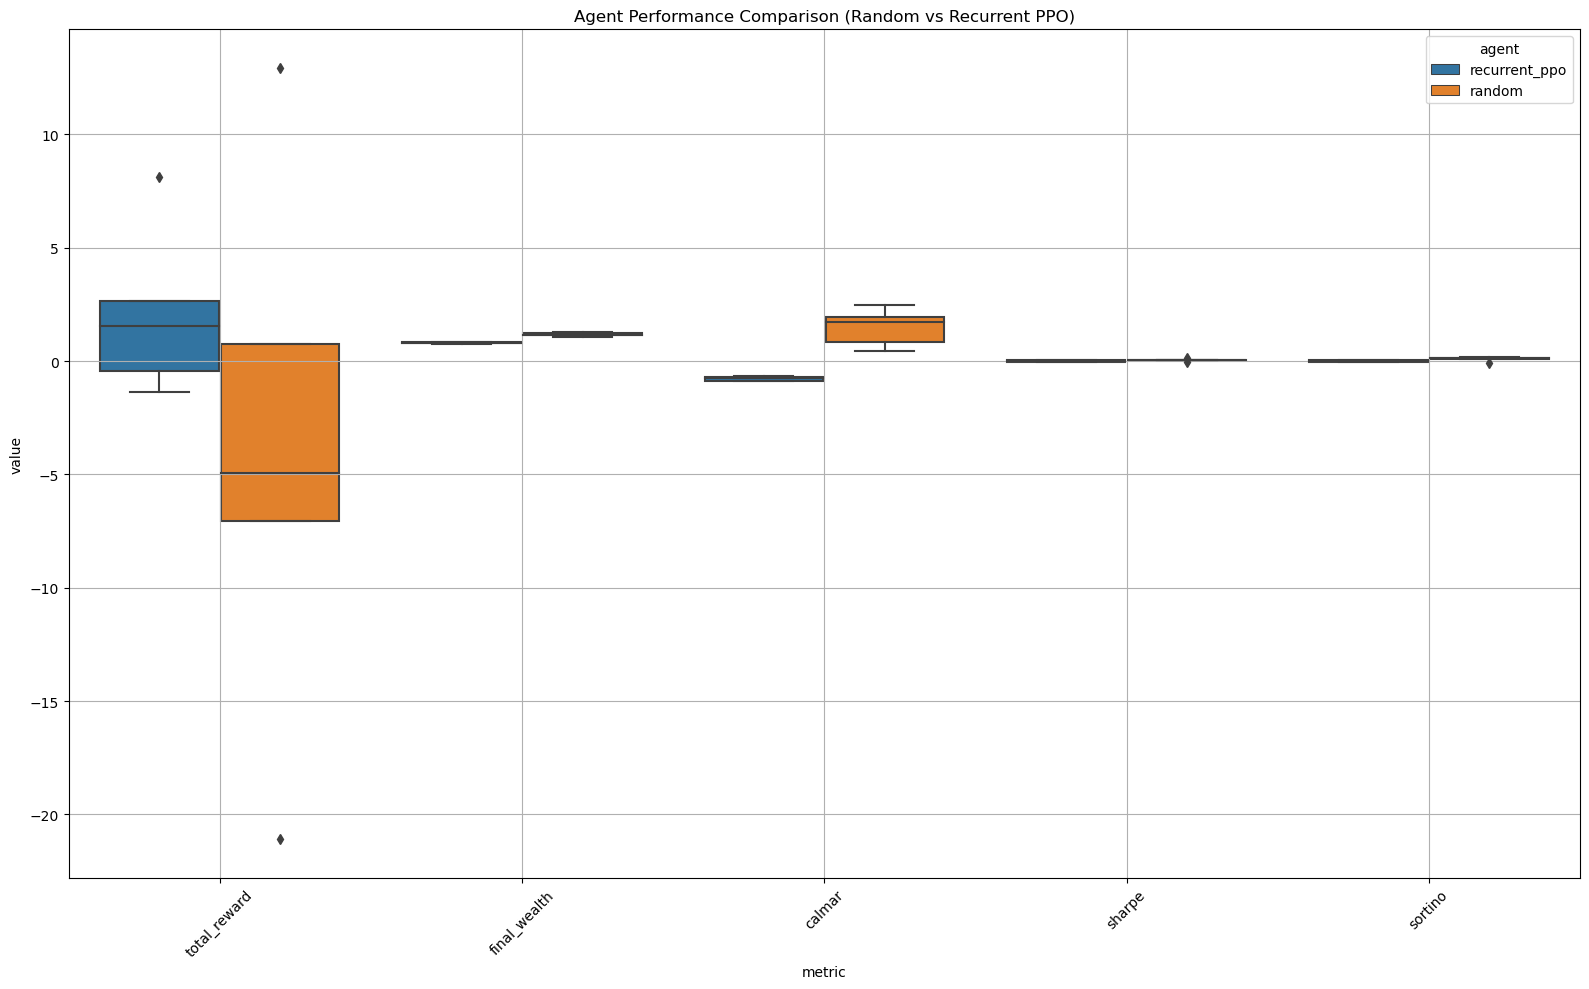

,metric,t-test p-value,mann-whitney p-value
0,total_reward,0.329916,0.309524
1,final_wealth,0.000012,0.007937
2,calmar,0.000323,0.007937
3,sharpe,0.269913,0.420635
4,sortino,0.159818,0.150794


In [24]:
# === Imports ===
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import ttest_ind, mannwhitneyu

from sb3_contrib import RecurrentPPO
#from src.env.base_timeseries_trading_env import SequenceAwareCumulativeTradingEnv
from src.defaults import TOP2_STOCK_BY_SECTOR, EPISODE_LENGTH
from src.data.feature_pipeline import load_base_dataframe
#from src.env.base_timeseries_trading_env import RegimeAugmentingWrapper


# === Config ===
N_EVAL_EPISODES = 5
MODEL_PATH = save_path

# === Load Data ===
ohlcv_df = load_base_dataframe()
test_df = ohlcv_df[(ohlcv_df['date'] >= "2023-07-01") & (ohlcv_df['date'] < "2024-01-01")]
test_df = test_df[test_df['symbol'].isin(TOP2_STOCK_BY_SECTOR)]


# === Evaluation Logic ===
def evaluate_agent(agent, env, n_episodes=22):
    episode_metrics = []
    action_counts = []


    for _ in tqdm(range(n_episodes), desc="Evaluating Agent"):
        obs, _ = env.reset()
        #print(">>> [Eval] Obs shape:", obs.shape)  # Check input dimensions

        done = False
        state = None
        rewards = []
        infos = []

        while not done:
            action, state = agent.predict(obs, state=state, deterministic=True)
            #print(action)
            #print(env.action_counts)
            obs, reward, done, _, info = env.step(action)
            rewards.append(reward)
            infos.append(info)

        _env = env.env.env
        
        agent_wealth = infos[-1].get("final_wealth", np.nan)         # Your agent
        market_wealth = np.prod(1 + _env.episode_df['market_return_1d'].values)       # Market index
        alpha = agent_wealth - market_wealth              # Skill
        metrics = {
            "total_reward": np.sum(rewards),
            "final_wealth": infos[-1].get("final_wealth", np.nan),
            "market_wealth": market_wealth,
            "calmar": infos[-1].get("calmar", np.nan),
            "sharpe": infos[-1].get("episode_sharpe", np.nan),
            "sortino": infos[-1].get("episode_sortino", np.nan),
            "alpha":alpha,
            "episode_id": env.env.env.episode_counter,
            "regime": infos[-1].get("regime",np.nan)
        }


        episode_metrics.append(metrics)
    
    print(">>> [Eval] Action counts:", pd.Series(action_counts).value_counts())
    return pd.DataFrame(episode_metrics)


def evaluate_random_agent(env, n_episodes=22):
    episode_metrics = []

    for i in tqdm(range(n_episodes), desc="Evaluating Random Agent"):
        obs, _ = env.reset()
        done = False
        rewards = []
        infos = []

        while not done:
            action = env.action_space.sample()
            obs, reward, done, _, info = env.step(action)
            rewards.append(reward)
            infos.append(info)

        _env = env.env.env
        
        agent_wealth = infos[-1].get("final_wealth", np.nan)         # Your agent
        market_wealth = np.prod(1 + _env.episode_df['market_return_1d'].values)       # Market index
        alpha = agent_wealth - market_wealth              # Skill
        metrics = {
            "total_reward": np.sum(rewards),
            "final_wealth": infos[-1].get("final_wealth", np.nan),
            "market_wealth": market_wealth,
            "calmar": infos[-1].get("calmar", np.nan),
            "sharpe": infos[-1].get("episode_sharpe", np.nan),
            "sortino": infos[-1].get("episode_sortino", np.nan),
            "alpha":alpha,
            "episode_id": env.env.env.episode_counter,
            "regime": infos[-1].get("regime",np.nan)
        }
        episode_metrics.append(metrics)

    return pd.DataFrame(episode_metrics)


# === Run Evaluation ===

model = RecurrentPPO.load(MODEL_PATH)

def make_test_env():
    eval_env =ENV_CLASS(test_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
    eval_env.set_episode_sequence(test_seq)
    return PerEpisodeRewardNormalizer(RegimeAugmentingWrapper(eval_env)) #RegimeAugmentingWrapper(ENV_CLASS(test_df, episode_length=EPISODE_LENGTH,feature_cols=FEATURE_COLS))

random_agent_df = evaluate_random_agent(make_test_env(), n_episodes=N_EVAL_EPISODES)
ppo_agent_df = evaluate_agent(model, make_test_env(), n_episodes=N_EVAL_EPISODES)


ppo_agent_df["agent"] = "recurrent_ppo"
random_agent_df["agent"] = "random"
results_df = pd.concat([ppo_agent_df, random_agent_df])


# === Plotting ===
melted = results_df.melt(id_vars="agent", var_name="metric", value_name="value")
plt.figure(figsize=(16, 10))
sns.boxplot(data=melted, x="metric", y="value", hue="agent")
plt.title("Agent Performance Comparison (Random vs Recurrent PPO)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# === Statistical Tests ===
comparison_results = []

for metric in ppo_agent_df.columns[:-1]:  # exclude 'agent'
    a = ppo_agent_df[metric].dropna()
    b = random_agent_df[metric].dropna()

    # Skip if either is empty
    if len(a) == 0 or len(b) == 0:
        print(f"Skipping metric {metric}: empty values")
        continue

    t_stat, p_val_t = ttest_ind(a, b)
    u_stat, p_val_u = mannwhitneyu(a, b, alternative='two-sided')
    comparison_results.append({
        "metric": metric,
        "t-test p-value": p_val_t,
        "mann-whitney p-value": p_val_u
    })

comparison_df = pd.DataFrame(comparison_results)
comparison_df



<Axes: xlabel='agent', ylabel='final_wealth'>

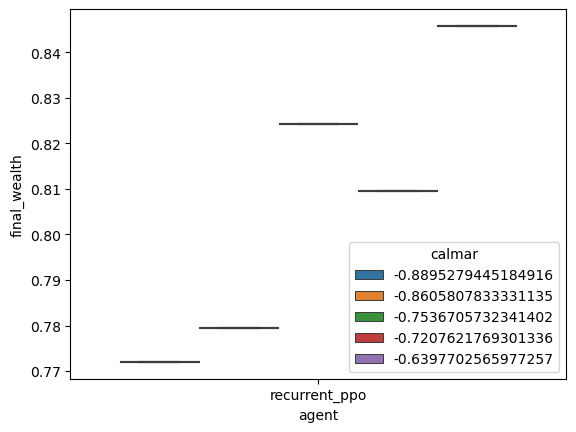

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=ppo_agent_df, x='market_wealth', y='alpha', hue='regime', alpha=0.2)

<Axes: xlabel='total_reward', ylabel='final_wealth'>

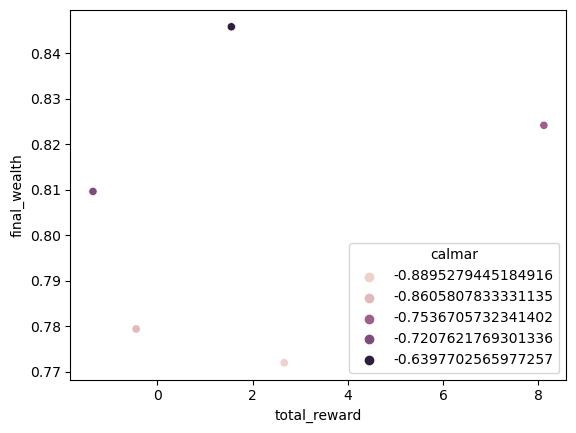

In [36]:

sns.scatterplot(data=ppo_agent_df, x='market_wealth', y='alpha', hue='agent')
plt.axhline(0, linestyle='--', color='red', label='Alpha = 0')
plt.legend()
plt.show()

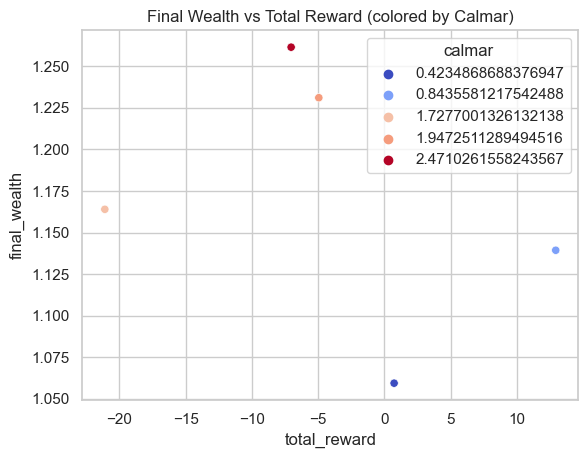

In [55]:
ppo_agent_df['alpha_ratio'] = ppo_agent_df['alpha'] / np.abs(ppo_agent_df['market_wealth'] + 1e-8)
sns.boxplot(data=ppo_agent_df, x='agent', y='alpha_ratio')

In [60]:
for f in FEATURE_COLS:
    print(f"{f}: {train_env.episode_df[f].corr(train_env.episode_df['return_1d'].shift(-1)):.4f}")

candle_body: 0.0393
candle_change: 0.1278
day_of_month: 0.0892
day_of_week: 0.1376
lower_shadow: 0.1453
market_return_1d: 0.0293
order_flow: -0.0755
order_flow_change: 0.0458
overnight_price_change: -0.1429
price_change: -0.1481
return_1d: -0.1481
trade_count_change: 0.1501
upper_shadow: -0.2076
vix_norm: 0.0561
volume_change: 0.2046
vwap_change: -0.1310


In [63]:
from xgboost import XGBRegressor
model = XGBRegressor()
df = train_env.episode_df.dropna()
X = df[FEATURE_COLS]
y = df['return_1d'].shift(-1).fillna(0)
model.fit(X, y)
importances = model.feature_importances_

In [64]:
importances

array([0.0341971 , 0.08832226, 0.01672027, 0.0458513 , 0.07812732,
       0.03731287, 0.02379431, 0.02857699, 0.02942792, 0.16061361,
       0.        , 0.04409018, 0.13293046, 0.07080062, 0.07806453,
       0.13117015], dtype=float32)

In [65]:
FEATURE_COLS

['candle_body',
 'candle_change',
 'day_of_month',
 'day_of_week',
 'lower_shadow',
 'market_return_1d',
 'order_flow',
 'order_flow_change',
 'overnight_price_change',
 'price_change',
 'return_1d',
 'trade_count_change',
 'upper_shadow',
 'vix_norm',
 'volume_change',
 'vwap_change']

                   feature  importance
9             price_change    0.160614
12            upper_shadow    0.132930
15             vwap_change    0.131170
1            candle_change    0.088322
4             lower_shadow    0.078127
14           volume_change    0.078065
13                vix_norm    0.070801
3              day_of_week    0.045851
11      trade_count_change    0.044090
5         market_return_1d    0.037313
0              candle_body    0.034197
8   overnight_price_change    0.029428
7        order_flow_change    0.028577
6               order_flow    0.023794
2             day_of_month    0.016720
10               return_1d    0.000000


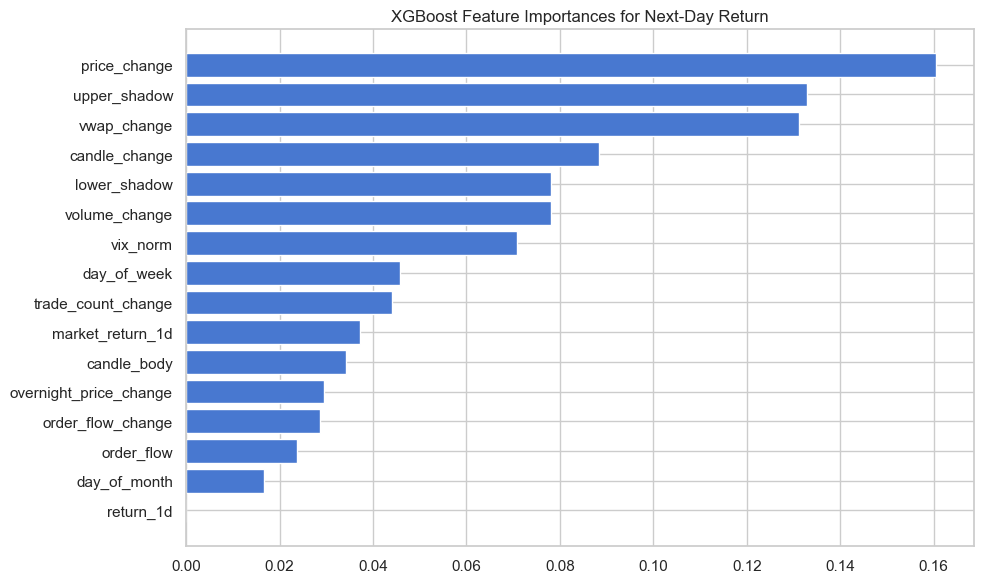

In [67]:
import matplotlib.pyplot as plt
feat_importance_df = pd.DataFrame({
    "feature": FEATURE_COLS,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feat_importance_df)
plt.figure(figsize=(10, 6))
plt.barh(feat_importance_df['feature'], feat_importance_df['importance'])
plt.title("XGBoost Feature Importances for Next-Day Return")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()